# Processing Embayment Constriction Mesurements

Google earth was used to measure the morphological characteristics to determine the Constriction Ratio of large coastal features around the world. This analysis will use k-means clustering to assess whether or not ther is a suitable subset of large coastal features which can be morphologically classified as Large 'Embayments'. The geological composition (Bedrock/Regolith) of the confining morphological structures can then be used to separate Barrier Estuaries from Large Structural Embayments (LSEs).

## Constriction Ratio

The constriction ratio is the ratio between the width of the mouth of a coastal feature at its thinnest point (L<sub>m</sub>), to the width of the embayed body of water at its widest point (L<sub>b</sub>) [Figure 1](#fig1).

<center>
    <a name="fig1">
        <img src="./test2.png" alt="drawing" width="300" />
    </a>
</center>


The constriction ratio is then given by the equation:

\begin{align}
C = L_m/L_b
\end{align}



## Mesuring Embayments on Google Earth

Identification of Coastal Features was peformed with an altitude set at 300km. Once a large coastal feature was identified, parameter measurement was conducted at a lower altitude to facilitate accurate measurment. Due to the real-world morphological complexity of Coastal Features, L<sub>m</sub> was measureed in multiple parts for Coastal Features with numerous significant mouths [Figure 2](#fig2).

<a name="fig2">
    <img src="./ComplexMorph.jpg" alt="ComplexMorph" width="1000"/>
</a>




## Cleaning Data

Measurements were manually recorded in Excel and then saved to a .csv file for cleaning and statistical analysis with Python. Because Lat and Long point measurements were recorded ([see pin in figure 2](#fig2)), GeoPandas will be used to import and clean the dataset.

### Importing data
Data is imported using geopands and the first 4 entries are displayed to provide a better sense of the dataset.

In [34]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import dms2dd as dd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

```note
Note: %matplotlib inline is used so that graphs are displayed in jupyter notebooks
```

In [2]:
df = pd.read_csv("./EmbaymentData_Prelim.csv", header=0)

In [3]:
df.head()

,Embayment,Alt Name,Papers,Descriptor,Type 1,Type 2,Size,Margin,Region,Country,...,Geology,P Lat,P Long,Lm,Lb,C,Unnamed: 19,L Inset,L Lat,L Long
0,Lake Illawarra,NaN,NaN,Lake,Barrier Estuary,COAST. PLAIN,Medium,Passive,Oceania,Australia,...,NaN,"34°31'21.44""S","150°50'18.66""E",414.0,8609.0,0.048089209,NaN,NaN,NaN,NaN
1,Grays Harbour,NaN,NaN,Harbour,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,NaN,"46°56'8.80""N","124° 3'9.33""W",3380.0,20147.0,0.167766913,NaN,NaN,NaN,NaN
2,Willapa Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,NaN,"46°34'7.17""N","123°58'59.52""W",6984.0,40235.0,0.173580216,NaN,NaN,NaN,NaN
3,Columbia River Estuary,NaN,NaN,Estuary,Barrier Estuary,Ria,NaN,Active,North America,United States of America,...,NaN,"46°12'57.47""N","123°50'37.45""W",5263.0,12263.0,0.4291772,NaN,NaN,NaN,NaN
4,San Diego Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,NaN,"32°40'31.64""N","117° 8'39.01""W",1422.0,17172.0,0.082809224,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['Embayment', 'Alt Name', 'Papers', 'Descriptor', 'Type 1', 'Type 2',
       'Size', 'Margin', 'Region', 'Country', 'Ocean/Water Body',
       'Climate Zone (Koppen)', 'Regional Process Dominance', 'Geology',
       'P Lat', 'P Long', 'Lm', 'Lb', 'C', 'Unnamed: 19', 'L Inset', 'L Lat',
       'L Long'],
      dtype='object')

### Cleaning
The relevant colums are:
- Embayment
- Type 1
- Margin
- Ocean/Water Body
- Climate Zone (Koppen)
- Regional Process Dominance
- P Lat
- P Long
- Lm
- Lb
- C

These will be subsetted from the dataset.

In [5]:
df2 = df[['Embayment', 
             'Type 1',
             'Margin',
             'Ocean/Water Body',
             'Climate Zone (Koppen)',
             'Regional Process Dominance',
             'P Lat',
             'P Long',
             'Lm',
             'Lb',
             'C']]

In [6]:
df2.head()

,Embayment,Type 1,Margin,Ocean/Water Body,Climate Zone (Koppen),Regional Process Dominance,P Lat,P Long,Lm,Lb,C
0,Lake Illawarra,Barrier Estuary,Passive,NaN,Cfb,Wave,"34°31'21.44""S","150°50'18.66""E",414.0,8609.0,0.048089209
1,Grays Harbour,Barrier Estuary,Active,NaN,Cfb,Wave,"46°56'8.80""N","124° 3'9.33""W",3380.0,20147.0,0.167766913
2,Willapa Bay,Barrier Estuary,Active,NaN,Cfb,Wave,"46°34'7.17""N","123°58'59.52""W",6984.0,40235.0,0.173580216
3,Columbia River Estuary,Barrier Estuary,Active,NaN,Cfb,Wave,"46°12'57.47""N","123°50'37.45""W",5263.0,12263.0,0.4291772
4,San Diego Bay,Barrier Estuary,Active,NaN,Bsk,Wave,"32°40'31.64""N","117° 8'39.01""W",1422.0,17172.0,0.082809224


In [7]:
df2.describe()

,Lm,Lb
count,109.000000,109.000000
mean,15900.614679,28514.917431
std,18513.732206,22815.635475
min,135.000000,2605.000000
25%,2122.000000,12263.000000
50%,8371.000000,21660.000000
75%,23507.000000,40235.000000
max,80096.000000,120752.000000


### Removing NA and #DIV/0!

Many of these cells do not have appropriate values in them. Because a fomula was applied across the C column in Excel, many NA values are actually read as #DIV/0!.

These will need to be removed alongside entries with little to no data entered. Since the main focus of this portion of the study is the C ratio, rows without Lm or Lb values will be removed and #DIV/0! values will be removed alongside them.

First we will replace empty values with numpys NaN using regex.

In [8]:
df2 = df2.replace('', np.nan)

#### Removing NaN

Pandas DataFrame.dropna() with the option subset=[] is used to drop rows where the L<sub>m</sub> and L<sub>b</sub> parameters are not measured.

In [9]:
dfclean = df.dropna(subset=['Lm', 'Lb', 'P Lat', 'P Long'])

In [10]:
dfclean

,Embayment,Alt Name,Papers,Descriptor,Type 1,Type 2,Size,Margin,Region,Country,...,Geology,P Lat,P Long,Lm,Lb,C,Unnamed: 19,L Inset,L Lat,L Long
0,Lake Illawarra,NaN,NaN,Lake,Barrier Estuary,COAST. PLAIN,Medium,Passive,Oceania,Australia,...,NaN,"34°31'21.44""S","150°50'18.66""E",414.0,8609.0,0.048089209,NaN,NaN,NaN,NaN
1,Grays Harbour,NaN,NaN,Harbour,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,NaN,"46°56'8.80""N","124° 3'9.33""W",3380.0,20147.0,0.167766913,NaN,NaN,NaN,NaN
2,Willapa Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,NaN,"46°34'7.17""N","123°58'59.52""W",6984.0,40235.0,0.173580216,NaN,NaN,NaN,NaN
3,Columbia River Estuary,NaN,NaN,Estuary,Barrier Estuary,Ria,NaN,Active,North America,United States of America,...,NaN,"46°12'57.47""N","123°50'37.45""W",5263.0,12263.0,0.4291772,NaN,NaN,NaN,NaN
4,San Diego Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,NaN,"32°40'31.64""N","117° 8'39.01""W",1422.0,17172.0,0.082809224,NaN,NaN,NaN,NaN
5,Ojo de Libre Lagoon,NaN,NaN,Lagoon,Barrier Estuary,NaN,NaN,Active,North America,Mexico,...,NaN,"27°45'8.47""N","114°11'42.58""W",3694.0,23733.0,0.155648253,NaN,NaN,NaN,NaN
6,Saint Ignacio Lagoon,Laguna San Ignacio,NaN,Lagoon,Barrier Estuary,Tidal Inlet,NaN,Active,North America,Mexico,...,NaN,"26°49'38.15""N","113°12'24.81""W",3848.0,6794.0,0.566382102,NaN,NaN,NaN,NaN
7,Lagoon of Caratasca,Laguna de Caratasca,NaN,Lagoon,Barrier Estuary,NaN,NaN,Active,Central America,Honduras,...,NaN,"15°21'21.71""N","83°50'7.78""W",562.0,50805.0,0.011061903,NaN,NaN,NaN,NaN
8,Términos Lagoon,Laguna de Términos,NaN,Lagoon,Barrier Estuary,Lagoon,NaN,Active,Central America,Mexico,...,NaN,"18°36'39.02""N","91°35'17.79""W",6660.0,72785.0,0.09150237,NaN,NaN,NaN,NaN
9,Tamiahua Lagoon,Laguna Tamiahua,NaN,Lagoon,Barrier Estuary,Lagoon,NaN,Passive,Central America,Mexico,...,NaN,"21°34'46.90""N","97°32'50.12""W",135.0,20346.0,0.006635211,NaN,NaN,NaN,NaN


### Data Types
Many of the datatypes in this table are now wrong

In [11]:
dfclean.dtypes

Embayment                      object
Alt Name                       object
Papers                         object
Descriptor                     object
Type 1                         object
Type 2                         object
Size                           object
Margin                         object
Region                         object
Country                        object
Ocean/Water Body               object
Climate Zone (Koppen)          object
Regional Process Dominance     object
Geology                        object
P Lat                          object
P Long                         object
Lm                            float64
Lb                            float64
C                              object
Unnamed: 19                   float64
L Inset                       float64
L Lat                          object
L Long                         object
dtype: object

## Data Analysis

In this section, a k-means cluster analysis is performed to group Coastal Features by C ratio. This should help to determine whether or not there is a LSE subclass. But first we will plot the coastal features as a scatter plot to see their distribution. 

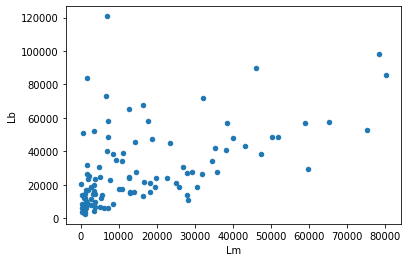

In [12]:
dfclean.plot.scatter(x='Lm', y='Lb')

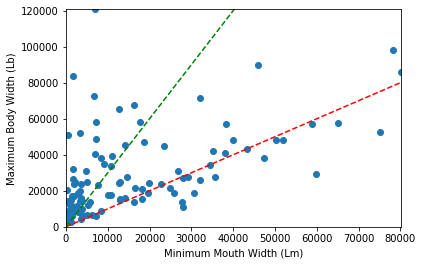

In [13]:

plt.scatter(x=dfclean['Lm'], y=dfclean['Lb'])
x=np.linspace(0, max(dfclean['Lb']), 100)
y=x
y2=3*x
plt.plot(x, y, 'r--')
plt.plot(x, y2, 'g--')
plt.axis([0, max(dfclean['Lm']), 0, max(dfclean['Lb'])])
plt.xlabel('Minimum Mouth Width (Lm)')
plt.ylabel('Maximum Body Width (Lb)')

plt.savefig("./images/ScatterPlot.svg")
plt.savefig("./images/ScatterPlot.png")

plt.show()

In this instance, the further away a point is from the red line, the more embayed a coastal feature is. The green line represents:
\begin{align}
\frac{L_m}{3L_b}
\end{align}
Which can also be stated as as $C=0.3$, an consequently anything above the ***green*** line is $< C=0.3$ and considered 'Embayed'. Additionally, any points on or below ***red*** line are considered open and the further away they are from the ***red*** line they are the more hypersynchronous they are.


### Global Distribution

The distribution of Coastal Features reviewed for this literature review can be displayed using geopandas. However geopandas works best if the latitude and longitude are in ***Decimal Degrees*** rather than their current format ***Degrees Minutes Seconds***. To solve this I have written a simple function which converts from ***DMS*** to ***DD***. This function can be applied to both latitude and longitude and then those values will be stored in a list alongside the ***Point*** geometry type for later plotting.

First conversion from ***DMS*** to ***DD***. Notethe use of custom scrip dd.convert

In [14]:
dfclean.loc[:,'Lat'] = dfclean.loc[:,'P Lat'].apply(dd.convert)
dfclean.loc[:,'Long'] = dfclean.loc[:,'P Long'].apply(dd.convert)


C:\Users\mpbaum\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\mpbaum\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
dfclean.head()

,Embayment,Alt Name,Papers,Descriptor,Type 1,Type 2,Size,Margin,Region,Country,...,P Long,Lm,Lb,C,Unnamed: 19,L Inset,L Lat,L Long,Lat,Long
0,Lake Illawarra,NaN,NaN,Lake,Barrier Estuary,COAST. PLAIN,Medium,Passive,Oceania,Australia,...,"150°50'18.66""E",414.0,8609.0,0.048089209,NaN,NaN,NaN,NaN,-34.522622,150.838517
1,Grays Harbour,NaN,NaN,Harbour,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,"124° 3'9.33""W",3380.0,20147.0,0.167766913,NaN,NaN,NaN,NaN,46.935778,-124.052592
2,Willapa Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,"123°58'59.52""W",6984.0,40235.0,0.173580216,NaN,NaN,NaN,NaN,46.568658,-123.983200
3,Columbia River Estuary,NaN,NaN,Estuary,Barrier Estuary,Ria,NaN,Active,North America,United States of America,...,"123°50'37.45""W",5263.0,12263.0,0.4291772,NaN,NaN,NaN,NaN,46.215964,-123.843736
4,San Diego Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,"117° 8'39.01""W",1422.0,17172.0,0.082809224,NaN,NaN,NaN,NaN,32.675456,-117.144169


Now we convert the DD lat long into Points from the Shapely.geometry module by:

In [16]:
geometry = [Point(x,y) for x,y in zip(dfclean['Long'], dfclean['Lat'])]

gfd=gpd.GeoDataFrame(dfclean, geometry=geometry)

Importing a world map to plot against:

In [17]:
world_url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson'
world = gpd.read_file(world_url)

In [18]:
world.head()

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,3,5,Netherlands,NL1,1,2,Country,Aruba,ABW,0,...,Americas,Caribbean,Latin America & Caribbean,5,5,5,4,-99,Admin-0 country,"POLYGON ((-69.89912109375 12.45200195312499, -..."
1,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,Asia,Southern Asia,South Asia,11,11,4,-99,1,Admin-0 country,"POLYGON ((74.89130859375001 37.231640625, 74.8..."
2,1,3,Angola,AGO,0,2,Sovereign country,Angola,AGO,0,...,Africa,Middle Africa,Sub-Saharan Africa,6,6,4,-99,1,Admin-0 country,"(POLYGON ((14.19082031250008 -5.8759765625, 14..."
3,1,6,United Kingdom,GB1,1,2,Dependency,Anguilla,AIA,0,...,Americas,Caribbean,Latin America & Caribbean,8,8,4,-99,-99,Admin-0 country,"POLYGON ((-63.001220703125 18.22177734374999, ..."
4,1,6,Albania,ALB,0,2,Sovereign country,Albania,ALB,0,...,Europe,Southern Europe,Europe & Central Asia,7,7,4,-99,1,Admin-0 country,"POLYGON ((20.06396484375 42.547265625, 20.1035..."


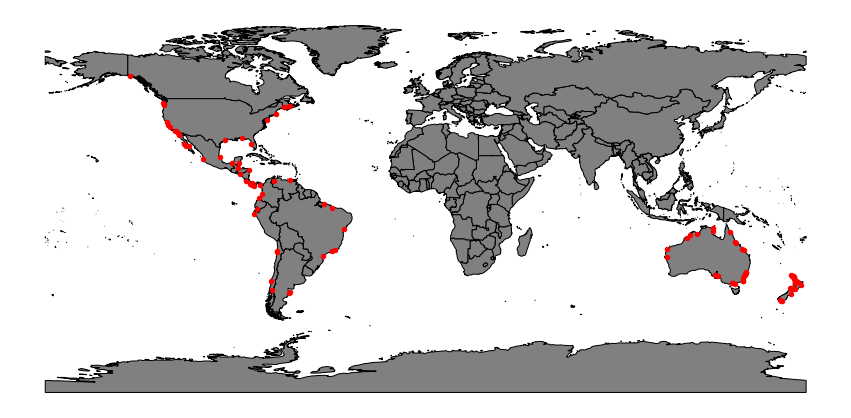

In [35]:
plt.rcParams['figure.figsize'] = [15, 10]
f, ax = plt.subplots(1)

world.plot(ax=ax, color='grey', edgecolor='black')

gfd.plot(ax=ax, marker='o', color='red', markersize=20)

plt.axis("off")

plt.savefig('./images/EmbaymentsWorld.svg')
plt.savefig('./images/EmbaymentsWorld.png')


# ***Ward Agglomerative Clustering***


Clustering analysis of the embayment measurements should yield morphological archetypes for large coastal features. This analysis will be conducted here using the kmeans module from sklearn.cluster package.First we create a subset of dfclean (because it is a Pandas DataFrame not a Geopandas GeoDataFrame) and store it in the variable ***X***. Then we set up the model options and store them in the variable ***kmeans***. Lastly, we create the model by applying the _KMeans.fit(X)_ method and store it in ***kluster***. ***kluster*** now contains the model and centroids for the cluster analysis that we just performed. 

### Using K-Means

I have modified this notebook to use instead AgglomerativeClustering from sklearn using the Ward method. Kmeans methods have been commented out but are still available to view. 

In [36]:
from sklearn.cluster import KMeans

X = dfclean[dfclean.loc[:,'Lm'].notna() & dfclean.loc[:,'Lb'].notna()]
kmeans = KMeans(n_clusters=7, max_iter=10000)
kluster = kmeans.fit(X.loc[:,["Lm","Lb"]])

### Cluster Centers

The computed cluster centers (we specified 3) are stored in the attribute ***cluster_centers_***. Calling this attribute shows that the centroid coordinates are stored in a numpy array (may be useful to know).

In [37]:
kluster.cluster_centers_


array([[  3874.29545455,  10925.38636364],
       [ 50286.41666667,  46907.08333333],
       [  7187.8125    ,  29617.875     ],
       [  4365.5       , 102281.5       ],
       [ 68115.33333333,  91153.        ],
       [ 25804.17647059,  22507.94117647],
       [ 13342.83333333,  56895.5       ]])

### Determining Cluster Category

Determination of each points 'Cluster' is done by applying the ***predict()*** method for each point in the DataFrame ***X***. Here we store those values in the column ***'Cluster'***.

In [38]:
X['Cluster'] = kluster.fit_predict(X.loc[:,["Lm","Lb"]])

In [39]:
X.head()

,Embayment,Alt Name,Papers,Descriptor,Type 1,Type 2,Size,Margin,Region,Country,...,Lb,C,Unnamed: 19,L Inset,L Lat,L Long,Lat,Long,geometry,Cluster
0,Lake Illawarra,NaN,NaN,Lake,Barrier Estuary,COAST. PLAIN,Medium,Passive,Oceania,Australia,...,8609.0,0.048089209,NaN,NaN,NaN,NaN,-34.522622,150.838517,POINT (150.8385166666667 -34.52262222222222),0
1,Grays Harbour,NaN,NaN,Harbour,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,20147.0,0.167766913,NaN,NaN,NaN,NaN,46.935778,-124.052592,POINT (-124.0525916666667 46.93577777777777),0
2,Willapa Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,40235.0,0.173580216,NaN,NaN,NaN,NaN,46.568658,-123.983200,POINT (-123.9832 46.56865833333334),2
3,Columbia River Estuary,NaN,NaN,Estuary,Barrier Estuary,Ria,NaN,Active,North America,United States of America,...,12263.0,0.4291772,NaN,NaN,NaN,NaN,46.215964,-123.843736,POINT (-123.8437361111111 46.21596388888889),0
4,San Diego Bay,NaN,NaN,Bay,Barrier Estuary,NaN,NaN,Active,North America,United States of America,...,17172.0,0.082809224,NaN,NaN,NaN,NaN,32.675456,-117.144169,POINT (-117.1441694444445 32.67545555555555),0


### Graphing

Now we can graphically display the cluster grouping using matplotlib.

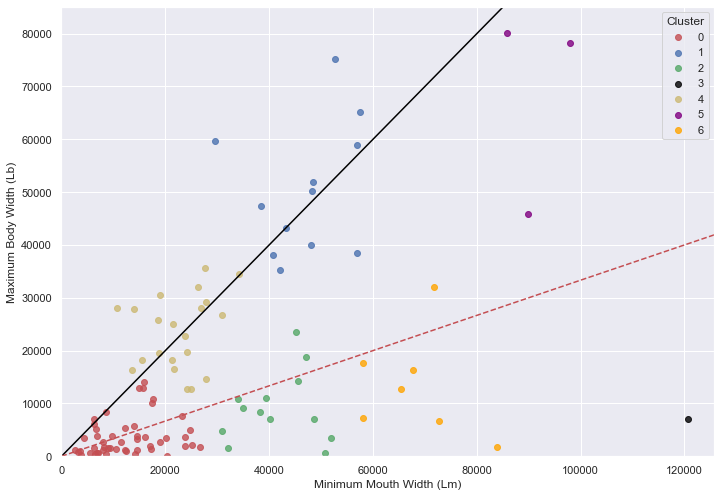

In [69]:

colours={0:'r',1:'b', 2:'g', 3:'black', 4: 'y', 5: 'purple', 6:'orange'}
shapes={'LSE': '*', 
        'Open':'s', 
        'Macrotidal': '^', 
        'Tidal Inlet':'X', 
        'Barrier Estuary':'d', 
        'Ria': 'o', 
        'Coastal Plain': 'p' ,
        'Fjord': '8'}

for cluster, group in X.groupby(['Cluster']): # plotting using a for loop see: https://stackoverflow.com/a/50239647
    plt.scatter(group['Lb'], group['Lm'], c=colours[cluster], alpha=0.8, label=cluster)

x=np.linspace(0, (max(X['Lm']) + 5000), 100)
leg1 = plt.legend(title='Cluster', loc='upper right')
y=x
x2=3*y
plt.plot(x, y, 'black')
plt.plot(x2, y, 'r--')
plt.axis([0, (max(dfclean['Lb'])+5000), 0, (max(dfclean['Lm'])+5000)])
plt.xlabel('Minimum Mouth Width (Lm)')
plt.ylabel('Maximum Body Width (Lb)')
plt.legend(title='Cluster')



plt.savefig('./images/Kluster1.svg')  # Saving the image
plt.savefig("./images/Kluster1.png")

plt.show()   # Showing the graph

# USING seaborn
#sns.pairplot(x_vars=["Lm"], y_vars=["Lb"], data=X, hue="Cluster", size=5)
#plt.axis([0, max(dfclean['Lm']), 0, max(dfclean['Lb'])])
#y=x
#y2=3*x
#plt.plot(x, y, 'black', label='C = 1.0')
#plt.plot(x, y2, 'r--', label='C < 0.3')
#plt.xlabel('Minimum Mouth Width (Lm)')
#plt.ylabel('Maximum Body Width (Lb)')
#
#plt.savefig('./images/Kluster1Seaborn.svg')  # Saving the image
#plt.savefig("./images/Kluster1Seaborn.png")

 #using plotnine ============
#X['Cluster'] = X['Cluster'].astype(object)
#p = ggplot(aes(x='Lm', y='Lb'), X)
#p = p + geom_point(aes(fill='Cluster', shape='Type 1'), size = 6)
#p =  p + xlab('Minimum Mouth Width (Lm)') + ylab('Maximum Body Width (Lb)')
#p = p + scale_fill_discrete(name='Cluster') + scale_shape_discrete(name='Coastal Feature Class')
#
#p

In [70]:
X.loc["Type 1"] = X["Type 1"].str.strip(" ")
X.loc["Cluster"] = X["Cluster"].apply(lambda x: str(x))
histdf = pd.crosstab(X["Type 1"], X["Cluster"] , values=X['Embayment'], aggfunc ='count', dropna=True)
X.to_csv('./DataOutput/ClusteredEmbayments.csv', header=True)
histdf.to_csv('./DataOutput/ClusterCrosstab.csv', header=True, index=True)
histdf

Cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Type 1,,,,,,,
Barrier Estuary,7.0,NaN,5.0,NaN,NaN,NaN,1.0
Coastal Plain,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Fjord,NaN,NaN,1.0,NaN,1.0,NaN,NaN
LSE,19.0,NaN,4.0,1.0,1.0,NaN,4.0
Macrotidal,2.0,2.0,1.0,NaN,7.0,1.0,NaN
Open,6.0,7.0,2.0,NaN,8.0,2.0,1.0
Ria,6.0,NaN,NaN,NaN,NaN,NaN,NaN
Tidal Inlet,8.0,NaN,NaN,NaN,1.0,NaN,NaN
